In [31]:
%pip install tensorflow-gpu

In [0]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [0]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [0]:
df = pd.read_csv(csv_path)

In [35]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [0]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [37]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d45d7a828>,
      dtype=object)

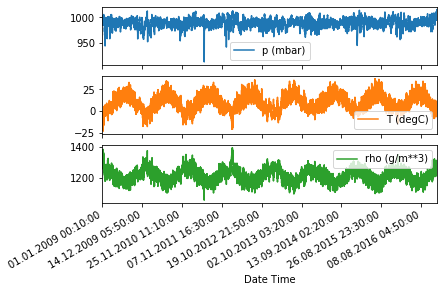

In [38]:
features.plot(subplots=True)

In [0]:
#Now let's normalize all the three columns 
features=features.values
data_mean = features.mean(axis=0)
data_std = features.std(axis=0)

In [40]:
print(data_mean)
print(data_std)

[ 989.2127761     9.45014735 1216.0627479 ]
[ 8.35847076  8.4233552  39.97516075]


In [0]:
#Z-score normalize 
features=(features-data_mean)/data_std

In [0]:
def multivariate_data(dataset,target_dataset,start,end,history,target,step,single_step=False):
  data=[]
  labels=[]

  start+=history
  if end is None:
    end=len(dataset)-target

  for i in range(start,end):
    indices=range(i-history,i,step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target_dataset[i+target])
    else:
      labels.append(target_dataset[i:i+target])
  
  return np.array(data),np.array(labels)

In [0]:
past_history = 720
future_target = 72
STEP = 6

TRAIN_SPLIT=300000

x_train_single, y_train_single = multivariate_data(features, features[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(features, features[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

In [46]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [0]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [0]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [50]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(256, 1)


In [52]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 9s 43ms/step - loss: 0.3288 - val_loss: 0.2619
Epoch 2/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2662 - val_loss: 0.2512
Epoch 3/10
200/200 [==============================] - 5s 25ms/step - loss: 0.2688 - val_loss: 0.2501
Epoch 4/10
200/200 [==============================] - 5s 27ms/step - loss: 0.2658 - val_loss: 0.2485
Epoch 5/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2307 - val_loss: 0.2431
Epoch 6/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2464 - val_loss: 0.2704
Epoch 7/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2485 - val_loss: 0.2597
Epoch 8/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2468 - val_loss: 0.2519
Epoch 9/10
200/200 [==============================] - 5s 26ms/step - loss: 0.2471 - val_loss: 0.2849
Epoch 10/10
200/200 [===========================

In [0]:
def plot(history,title):
  history=history.history
  loss=history['loss']
  val_loss=history['val_loss']

  epochs=range(1,len(loss)+1)

  plt.figure()
  plt.plot(epochs,loss,'r',label='Training Loss')
  plt.plot(epochs,val_loss,'b',label='Validation Loss')
  plt.title(title)
  plt.legend()

  plt.show()

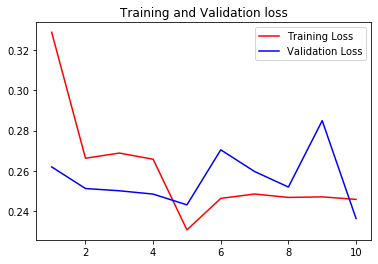

In [58]:
plot(single_step_history,'Training and Validation loss')

In [0]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt